In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.metadata.utils import dtype
from chardet import detect
from dask.array import argmax
from numba import float64
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from AWG_function import *

In [2]:
inst=connect_PXI()

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: Tabor Electronics,P9484M,000002243278,1.237.0 --slot#: 8,


In [3]:
# configurate the detected pulse
detect_pulse_freq=30E6
detect_pulse_length=160
detect_pulse_length_s=detect_pulse_length/SampleRateDAC_IQ
t_acquire_pulse=np.linspace(0,detect_pulse_length_s,detect_pulse_length,endpoint=False)

detect_I=np.cos(2*np.pi*detect_pulse_freq*t_acquire_pulse)/2
detect_Q=np.sin(2*np.pi*detect_pulse_freq*t_acquire_pulse)/2

In [4]:
carrier_frequency=100E6
configurate_one_DAC(inst=inst,channel=1,carrier_frequency=carrier_frequency,trigger_channel=1)

empty_1 = segment(inst=inst, segnum=2)
empty_1.default_pulse(length=640, amplitude=0.5, phase=0, type='empty')
empty_1.compile_and_download_segment()

detect_pulse=segment(inst=inst,segnum=1)
detect_pulse.custom_pulse(detect_I,detect_Q)
detect_pulse.compile_and_download_segment()

empty_2 = segment(inst=inst, segnum=2)
empty_2.default_pulse(length=480, amplitude=0.5, phase=0, type='empty')
empty_2.compile_and_download_segment()

ch1_task=task_table(inst=inst,length=3)
ch1_task.new_task(tasknum=1,segnum=1,ext_trigger_ch=1,digitizer_trigger=False,next_task=2)
ch1_task.new_task(tasknum=2,segnum=2,ext_trigger_ch=0,digitizer_trigger=True,next_task=3)
ch1_task.new_task(tasknum=3,segnum=1,ext_trigger_ch=0,digitizer_trigger=False,next_task=1)
ch1_task.download_task_table()

DAC sample rate 1.00GS/s, SCLK 8.00GS/s
DAC minimum segment length 32.0ns, segment granularity 16.0ns
DAC configuration successful
channel 1, segment 2 downloaded, length 640.0ns
channel 1, segment 1 downloaded, length 160.0ns
channel 1, segment 2 downloaded, length 480.0ns
channel 1 task table downloaded


In [5]:
# configurate acquisition pulse
acq_frame_len=96
acq_frame_len_s=96/SampleRateADC_IQ
acquire_pulse_freq=30E6
acquire_pulse_length=96
acquire_pulse_length_s=acquire_pulse_length/SampleRateDAC_IQ
t_acquire_pulse=np.linspace(0,acquire_pulse_length_s,acquire_pulse_length)

acquire_I=np.cos(2*np.pi*acquire_pulse_freq*t_acquire_pulse)/2
acquire_Q=np.sin(2*np.pi*acquire_pulse_freq*t_acquire_pulse)/2

In [6]:
carrier_frequency=100E6
configurate_one_DAC(inst=inst,channel=3,carrier_frequency=carrier_frequency,trigger_channel=1)

empty = segment(inst=inst, segnum=1)
empty.default_pulse(length=640, amplitude=0.5, phase=0, type='empty')
empty.compile_and_download_segment()

detection_pulse=segment(inst=inst,segnum=2)
detection_pulse.custom_pulse(acquire_I,acquire_Q)
detection_pulse.compile_and_download_segment()

ch3_task=task_table(inst=inst,length=2)
ch3_task.new_task(tasknum=1,segnum=1,ext_trigger_ch=1,digitizer_trigger=False,next_task=2)
ch3_task.new_task(tasknum=2,segnum=2,ext_trigger_ch=0,digitizer_trigger=True,next_task=1)
ch3_task.download_task_table()

DAC sample rate 1.00GS/s, SCLK 8.00GS/s
DAC minimum segment length 32.0ns, segment granularity 16.0ns
DAC configuration successful
channel 3, segment 1 downloaded, length 640.0ns
channel 3, segment 2 downloaded, length 96.0ns
channel 3 task table downloaded


In [7]:
ch1_digitizer=digitizer(address={'inst':inst,'channel':1},task_trigger_channel=1,carrier_frequency=carrier_frequency,numframes=100,framelen_IQ=acq_frame_len)
ch3_digitizer=digitizer(address={'inst':inst,'channel':2},task_trigger_channel=3,carrier_frequency=carrier_frequency,numframes=100,framelen_IQ=acq_frame_len)

digitizer sample rate 0.12GS/s, SCLK 2.00GS/s
digitizer granularity 384.0ns
Channel 1 acquisition frame Length 768.0 ns, frame number 100
digitizer sample rate 0.12GS/s, SCLK 2.00GS/s
digitizer granularity 384.0ns
Channel 2 acquisition frame Length 768.0 ns, frame number 100


In [9]:
print(ch1_digitizer.inquire_acquisition())
print(ch3_digitizer.inquire_acquisition())

(1, 100)
(1, 100)


In [10]:
ch1_digitizer.read_digitizer_data()
ch3_digitizer.read_digitizer_data()

Total read size in bytes: 76800
acquired 9600 complex points, 76800.0ns
Total read size in bytes: 76800
acquired 9600 complex points, 76800.0ns


In [11]:
data=EPR_data(ch1_digitizer,ch3_digitizer,10)

recognize 10 experiments, 10 repetitions, length 768.0ns, 96 samples


In [12]:
data.interpolation()

interpolation completed, signal length 1536


In [13]:
data.align()

array([  0,   0,   0, -28, -28, -28,  -2,  -2, -30, -30, -30,  -4,  -4,
        -4, -32, -32,  -6,  -6,  -6, -34, -34, -34,  -8,  -8, -36, -36,
       -36, -10, -10, -10, -38, -38, -12, -12, -12, -40, -40, -40,   2,
         2, -26, -26, -26,   0,   0, -28, -28, -28,  -2,  -2,  -2, -30,
       -30,  -4,  -4,  -4, -32, -32, -32,  -6,  -6,  -6, -34, -34,  -8,
        -8,  -8, -36, -36, -10, -10, -10, -38, -38, -38, -12, -12, -40,
       -40, -40,   2,   2, -26, -26, -26,   0,   0,   0, -28, -28,  -2,
        -2,  -2, -30, -30, -30,  -4,  -4, -32, -32])

In [14]:
data.fix_error(3)

[array([0, 1, 2], dtype=int64),
 array([1, 2, 3], dtype=int64),
 array([2, 3, 7], dtype=int64),
 array([2, 3, 4], dtype=int64),
 array([3, 4, 8], dtype=int64),
 array([0, 3, 4], dtype=int64),
 array([0, 1, 4], dtype=int64),
 array([0, 1, 5], dtype=int64),
 array([0, 1, 5], dtype=int64),
 array([0, 1, 2], dtype=int64)]

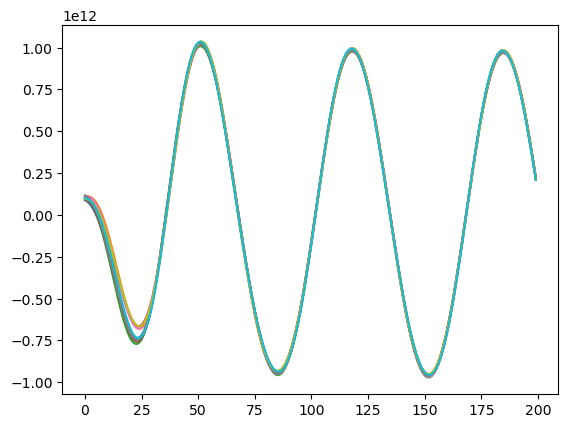

In [15]:
for i in range(10):
    plt.plot(np.real(data.average[i])[900:1100])